In [ ]:
!pip install transformers sentencepiece datasets

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 8.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 521.2/521.2 kB 13.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 115.3/115.3 kB 12.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 16.0 MB/s eta 0:00:00


In [ ]:
from datasets import load_dataset
from google.colab import drive
from IPython.display import display
from IPython.html import widgets
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import torch
from torch import optim
from torch.nn import functional as F
from transformers import AdamW, AutoModelForSeq2SeqLM, AutoTokenizer
from transformers import get_linear_schedule_with_warmup
from tqdm import tqdm_notebook

sns.set()

/usr/local/lib/python3.10/dist-packages/IPython/html.py:12: ShimWarning: The `IPython.html` package has been deprecated since IPython 4.0. You should import from `notebook` instead. `IPython.html.widgets` has moved to `ipywidgets`.
  warn("The `IPython.html` package has been deprecated since IPython 4.0. "


In [ ]:
# Use 'google/mt5-small' for non-pro cloab users
model_repo = 'google/mt5-base'
max_seq_len = 20

# Load Tokenizer & Model

In [ ]:
tokenizer = AutoTokenizer.from_pretrained(model_repo)

tokenizer_config.json:   0%|          | 0.00/376 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/702 [00:00<?, ?B/s]

spiece.model:   0%|          | 0.00/4.31M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/65.0 [00:00<?, ?B/s]

You are using the default legacy behaviour of the <class 'transformers.models.t5.tokenization_t5.T5Tokenizer'>. This is expected, and simply means that the `legacy` (previous) behavior will be used so nothing changes for you. If you want to use the new behaviour, set `legacy=False`. This should only be set if you understand what it means, and thouroughly read the reason why this was added as explained in https://github.com/huggingface/transformers/pull/24565
/usr/local/lib/python3.10/dist-packages/transformers/convert_slow_tokenizer.py:473: UserWarning: The sentencepiece tokenizer that you are converting to a fast tokenizer uses the byte fallback option which is not implemented in the fast tokenizers. In practice this means that the fast version of the tokenizer can produce unknown tokens whereas the sentencepiece version would have converted these unknown tokens into a sequence of byte tokens matching the original piece of text.
  warnings.warn(


In [ ]:
# Model description: https://huggingface.co/google/mt5-base
model = AutoModelForSeq2SeqLM.from_pretrained(model_repo)
model = model.cuda()

pytorch_model.bin:   0%|          | 0.00/2.33G [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/147 [00:00<?, ?B/s]

# Overview and Quick Test

In [ ]:
token_ids = tokenizer.encode(
    '<jp> This will be translated to Japanese! (hopefully)',
    return_tensors='pt').cuda()
print(token_ids)

model_out = model.generate(token_ids)
print(model_out)

output_text = tokenizer.convert_tokens_to_string(
    tokenizer.convert_ids_to_tokens(model_out[0]))
print(output_text)

tensor([[  1042,   3889,    669,   1494,    898,    390,  37194,    285,    288,
          30865,    309,    274, 116024,  11994,    271,      1]],
       device='cuda:0')


/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1273: UserWarning: Using the model-agnostic default `max_length` (=20) to control the generation length. We recommend setting `max_new_tokens` to control the maximum length of the generation.
  warnings.warn(


tensor([[     0, 250099,    259,    264,    259, 228700,      1]],
       device='cuda:0')
<pad> <extra_id_0> - issuu</s>


# Steps
1. Load the pretrained model and tokenizer
2. Load dataset
3. Transform dataset into input (entails a minor model change)
4. Train/finetune the model on our dataset
5. Test the model

# Test Tokenizer

In [ ]:
example_input_str = '<hi> I repeat this is the drill.'
# example_input_str = 'मैं दोहराता हूं कि यह ड्रिल है'
input_ids = tokenizer.encode(example_input_str, return_tensors='pt')
print('Input IDs:', input_ids)

tokens = tokenizer.convert_ids_to_tokens(input_ids[0])
print('Tokens:', tokens)

Input IDs: tensor([[ 1042,  1500,   669,   336,   259, 10315,   714,   339,   287,   259,
         76456,   260,     1]])
Tokens: ['▁<', 'hi', '>', '▁I', '▁', 'repeat', '▁this', '▁is', '▁the', '▁', 'drill', '.', '</s>']


In [ ]:
sorted(tokenizer.vocab.items(), key=lambda x: x[1])

[('<pad>', 0),
 ('</s>', 1),
 ('<unk>', 2),
 ('<0x00>', 3),
 ('<0x01>', 4),
 ('<0x02>', 5),
 ('<0x03>', 6),
 ('<0x04>', 7),
 ('<0x05>', 8),
 ('<0x06>', 9),
 ('<0x07>', 10),
 ('<0x08>', 11),
 ('<0x09>', 12),
 ('<0x0A>', 13),
 ('<0x0B>', 14),
 ('<0x0C>', 15),
 ('<0x0D>', 16),
 ('<0x0E>', 17),
 ('<0x0F>', 18),
 ('<0x10>', 19),
 ('<0x11>', 20),
 ('<0x12>', 21),
 ('<0x13>', 22),
 ('<0x14>', 23),
 ('<0x15>', 24),
 ('<0x16>', 25),
 ('<0x17>', 26),
 ('<0x18>', 27),
 ('<0x19>', 28),
 ('<0x1A>', 29),
 ('<0x1B>', 30),
 ('<0x1C>', 31),
 ('<0x1D>', 32),
 ('<0x1E>', 33),
 ('<0x1F>', 34),
 ('<0x20>', 35),
 ('<0x21>', 36),
 ('<0x22>', 37),
 ('<0x23>', 38),
 ('<0x24>', 39),
 ('<0x25>', 40),
 ('<0x26>', 41),
 ('<0x27>', 42),
 ('<0x28>', 43),
 ('<0x29>', 44),
 ('<0x2A>', 45),
 ('<0x2B>', 46),
 ('<0x2C>', 47),
 ('<0x2D>', 48),
 ('<0x2E>', 49),
 ('<0x2F>', 50),
 ('<0x30>', 51),
 ('<0x31>', 52),
 ('<0x32>', 53),
 ('<0x33>', 54),
 ('<0x34>', 55),
 ('<0x35>', 56),
 ('<0x36>', 57),
 ('<0x37>', 58),
 ('<0x38>',

# Prepare Dataset

In [ ]:
# Source: https://huggingface.co/datasets/alt
dataset = load_dataset('alt')

Generating train split:   0%|          | 0/18088 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/1000 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/1019 [00:00<?, ? examples/s]

In [ ]:
train_dataset = dataset['train']
test_dataset = dataset['test']

In [ ]:
train_dataset[0]

{'SNT.URLID': '80188',
 'SNT.URLID.SNTID': '1',
 'url': 'http://en.wikinews.org/wiki/2007_Rugby_World_Cup:_Italy_31_-_5_Portugal',
 'translation': {'bg': 'ফ্রান্সের প্যারিসের পার্ক দি প্রিন্সেস-এ হওয়া ২০০৭-এর রাগবি বিশ্বকাপের পুল সি-তে ইটালি পর্তুগালকে ৩১-৫ গোলে হারিয়েছে।',
  'en': 'Italy have defeated Portugal 31-5 in Pool C of the 2007 Rugby World Cup at Parc des Princes, Paris, France.',
  'en_tok': 'Italy have defeated Portugal 31-5 in Pool C of the 2007 Rugby World Cup at Parc des Princes , Paris , France .',
  'fil': 'Natalo ng Italya ang Portugal sa puntos na 31-5 sa Grupong C noong 2007 sa Pandaigdigang laro ng Ragbi sa Parc des Princes, Paris, France.',
  'hi': '2007 में फ़्रांस, पेरिस के पार्क डेस प्रिंसेस में हुए रग्बी विश्व कप के पूल C में इटली ने पुर्तगाल को 31-5 से हराया।',
  'id': 'Italia berhasil mengalahkan Portugal 31-5 di grup C dalam Piala Dunia Rugby 2007 di Parc des Princes, Paris, Perancis.',
  'ja': 'フランスのパリ、パルク・デ・プランスで行われた2007年ラグビーワールドカップのプールCで、イタリアは31対5でポルトガルを

In [ ]:
LANG_TOKEN_MAPPING = {
    'en': '<en>',
    'hi': '<hi>',
    'zh': '<zh>'
}

In [ ]:
special_tokens_dict = {'additional_special_tokens': list(LANG_TOKEN_MAPPING.values())}
tokenizer.add_special_tokens(special_tokens_dict)
model.resize_token_embeddings(len(tokenizer))

Embedding(250103, 768)

In [ ]:
token_ids = tokenizer.encode(
    example_input_str, return_tensors='pt', padding='max_length',
    truncation=True, max_length=max_seq_len)
print(token_ids)

tokens = tokenizer.convert_ids_to_tokens(token_ids[0])
print(tokens)

tensor([[250102,    336,    259,  10315,    714,    339,    287,    259,  76456,
            260,      1,      0,      0,      0,      0,      0,      0,      0,
              0,      0]])
['<hi>', '▁I', '▁', 'repeat', '▁this', '▁is', '▁the', '▁', 'drill', '.', '</s>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>']


In [ ]:
def encode_input_str(text, target_lang, tokenizer, seq_len,
                     lang_token_map=LANG_TOKEN_MAPPING):
  target_lang_token = lang_token_map[target_lang]

  # Tokenize and add special tokens
  input_ids = tokenizer.encode(
      text = target_lang_token + text,
      return_tensors = 'pt',
      padding = 'max_length',
      truncation = True,
      max_length = seq_len)

  return input_ids[0]

def encode_target_str(text, tokenizer, seq_len,
                      lang_token_map=LANG_TOKEN_MAPPING):
  token_ids = tokenizer.encode(
      text = text,
      return_tensors = 'pt',
      padding = 'max_length',
      truncation = True,
      max_length = seq_len)

  return token_ids[0]

def format_translation_data(translations, lang_token_map,
                            tokenizer, seq_len=128):
  # Choose a random 2 languages for in i/o
  langs = list(lang_token_map.keys())
  input_lang, target_lang = np.random.choice(langs, size=2, replace=False)

  # Get the translations for the batch
  input_text = translations[input_lang]
  target_text = translations[target_lang]

  if input_text is None or target_text is None:
    return None

  input_token_ids = encode_input_str(
      input_text, target_lang, tokenizer, seq_len, lang_token_map)

  target_token_ids = encode_target_str(
      target_text, tokenizer, seq_len, lang_token_map)

  return input_token_ids, target_token_ids

def transform_batch(batch, lang_token_map, tokenizer):
  inputs = []
  targets = []
  for translation_set in batch['translation']:
    formatted_data = format_translation_data(
        translation_set, lang_token_map, tokenizer, max_seq_len)

    if formatted_data is None:
      continue

    input_ids, target_ids = formatted_data
    inputs.append(input_ids.unsqueeze(0))
    targets.append(target_ids.unsqueeze(0))

  batch_input_ids = torch.cat(inputs).cuda()
  batch_target_ids = torch.cat(targets).cuda()

  return batch_input_ids, batch_target_ids

def get_data_generator(dataset, lang_token_map, tokenizer, batch_size=32):
  dataset = dataset.shuffle()
  for i in range(0, len(dataset), batch_size):
    raw_batch = dataset[i:i+batch_size]
    yield transform_batch(raw_batch, lang_token_map, tokenizer)

In [ ]:
# Testing `data_transform`
in_ids, out_ids = format_translation_data(
    train_dataset[0]['translation'], LANG_TOKEN_MAPPING, tokenizer)

print(' '.join(tokenizer.convert_ids_to_tokens(in_ids)))
print(' '.join(tokenizer.convert_ids_to_tokens(out_ids)))

# Testing data generator
data_gen = get_data_generator(train_dataset, LANG_TOKEN_MAPPING, tokenizer, 8)
data_batch = next(data_gen)
print('Input shape:', data_batch[0].shape)
print('Output shape:', data_batch[1].shape)

<zh> ▁2007 ▁में ▁फ़ ्रा ंस , ▁पे रिस ▁के ▁पार् क ▁डे स ▁ प्रि ंस ेस ▁में ▁हु ए ▁ र ग् बी ▁विश्व ▁कप ▁के ▁पू ल ▁C ▁में ▁ इट ली ▁ने ▁पुर् त गाल ▁को ▁3 1-5 ▁से ▁हर ाया । </s> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad>
▁ 意大利 在 法国 巴黎 王子 公园 体育 场 举办 的 2007 年 橄 榄 球 世界杯 C 组 以 3 1-5 击 败 葡萄 牙 。 </s> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pa

# Train/Finetune BERT

In [ ]:
# Constants
n_epochs = 8
batch_size = 16
print_freq = 50
checkpoint_freq = 1000
lr = 5e-4
n_batches = int(np.ceil(len(train_dataset) / batch_size))
total_steps = n_epochs * n_batches
n_warmup_steps = int(total_steps * 0.01)

In [ ]:
# Optimizer
optimizer = AdamW(model.parameters(), lr=lr)
scheduler = get_linear_schedule_with_warmup(
    optimizer, n_warmup_steps, total_steps)

/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


In [ ]:
losses = []

In [ ]:
def eval_model(model, gdataset, max_iters=8):
  test_generator = get_data_generator(gdataset, LANG_TOKEN_MAPPING,
                                      tokenizer, batch_size)
  eval_losses = []
  for i, (input_batch, label_batch) in enumerate(test_generator):
    if i >= max_iters:
      break

    model_out = model.forward(
        input_ids = input_batch,
        labels = label_batch)
    eval_losses.append(model_out.loss.item())

  return np.mean(eval_losses)

In [ ]:
for epoch_idx in range(n_epochs):
  # Randomize data order
  data_generator = get_data_generator(train_dataset, LANG_TOKEN_MAPPING,
                                      tokenizer, batch_size)

  for batch_idx, (input_batch, label_batch) \
      in tqdm_notebook(enumerate(data_generator), total=n_batches):
    optimizer.zero_grad()

    # Forward pass
    model_out = model.forward(
        input_ids = input_batch,
        labels = label_batch)

    # Calculate loss and update weights
    loss = model_out.loss
    losses.append(loss.item())
    loss.backward()
    optimizer.step()
    scheduler.step()

    # Print training update info
    if (batch_idx + 1) % print_freq == 0:
      avg_loss = np.mean(losses[-print_freq:])
      print('Epoch: {} | Step: {} | Avg. loss: {:.3f} | lr: {}'.format(
          epoch_idx+1, batch_idx+1, avg_loss, scheduler.get_last_lr()[0]))

    if (batch_idx + 1) % checkpoint_freq == 0:
      test_loss = eval_model(model, test_dataset)
      print('Saving model with test loss of {:.3f}'.format(test_loss))

<ipython-input-22-aaa70d134859>:7: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  in tqdm_notebook(enumerate(data_generator), total=n_batches):


  0%|          | 0/1131 [00:00<?, ?it/s]

Epoch: 1 | Step: 50 | Avg. loss: 11.343 | lr: 0.0002777777777777778
Epoch: 1 | Step: 100 | Avg. loss: 5.925 | lr: 0.0004994418396963608
Epoch: 1 | Step: 150 | Avg. loss: 4.585 | lr: 0.0004966510381781648
Epoch: 1 | Step: 200 | Avg. loss: 4.032 | lr: 0.0004938602366599688
Epoch: 1 | Step: 250 | Avg. loss: 3.651 | lr: 0.0004910694351417727
Epoch: 1 | Step: 300 | Avg. loss: 3.553 | lr: 0.0004882786336235767
Epoch: 1 | Step: 350 | Avg. loss: 3.373 | lr: 0.0004854878321053807
Epoch: 1 | Step: 400 | Avg. loss: 3.269 | lr: 0.00048269703058718467
Epoch: 1 | Step: 450 | Avg. loss: 3.201 | lr: 0.0004799062290689886
Epoch: 1 | Step: 500 | Avg. loss: 3.146 | lr: 0.00047711542755079264
Epoch: 1 | Step: 550 | Avg. loss: 3.012 | lr: 0.00047432462603259657
Epoch: 1 | Step: 600 | Avg. loss: 2.894 | lr: 0.00047153382451440055
Epoch: 1 | Step: 650 | Avg. loss: 2.819 | lr: 0.00046874302299620453
Epoch: 1 | Step: 700 | Avg. loss: 2.836 | lr: 0.00046595222147800846
Epoch: 1 | Step: 750 | Avg. loss: 2.802 | 

  0%|          | 0/1131 [00:00<?, ?it/s]

Epoch: 2 | Step: 50 | Avg. loss: 2.547 | lr: 0.0004391047108729627
Epoch: 2 | Step: 100 | Avg. loss: 2.490 | lr: 0.00043631390935476675
Epoch: 2 | Step: 150 | Avg. loss: 2.509 | lr: 0.0004335231078365707
Epoch: 2 | Step: 200 | Avg. loss: 2.432 | lr: 0.0004307323063183746
Epoch: 2 | Step: 250 | Avg. loss: 2.541 | lr: 0.00042794150480017864
Epoch: 2 | Step: 300 | Avg. loss: 2.438 | lr: 0.00042515070328198257
Epoch: 2 | Step: 350 | Avg. loss: 2.403 | lr: 0.00042235990176378655
Epoch: 2 | Step: 400 | Avg. loss: 2.429 | lr: 0.00041956910024559054
Epoch: 2 | Step: 450 | Avg. loss: 2.456 | lr: 0.0004167782987273945
Epoch: 2 | Step: 500 | Avg. loss: 2.361 | lr: 0.0004139874972091985
Epoch: 2 | Step: 550 | Avg. loss: 2.388 | lr: 0.0004111966956910025
Epoch: 2 | Step: 600 | Avg. loss: 2.358 | lr: 0.0004084058941728064
Epoch: 2 | Step: 650 | Avg. loss: 2.372 | lr: 0.00040561509265461045
Epoch: 2 | Step: 700 | Avg. loss: 2.370 | lr: 0.0004028242911364144
Epoch: 2 | Step: 750 | Avg. loss: 2.453 | l

  0%|          | 0/1131 [00:00<?, ?it/s]

Epoch: 3 | Step: 50 | Avg. loss: 2.188 | lr: 0.00037597678053136863
Epoch: 3 | Step: 100 | Avg. loss: 2.210 | lr: 0.00037318597901317256
Epoch: 3 | Step: 150 | Avg. loss: 2.233 | lr: 0.0003703951774949766
Epoch: 3 | Step: 200 | Avg. loss: 2.165 | lr: 0.0003676043759767805
Epoch: 3 | Step: 250 | Avg. loss: 2.179 | lr: 0.00036481357445858456
Epoch: 3 | Step: 300 | Avg. loss: 2.222 | lr: 0.0003620227729403885
Epoch: 3 | Step: 350 | Avg. loss: 2.191 | lr: 0.0003592319714221924
Epoch: 3 | Step: 400 | Avg. loss: 2.187 | lr: 0.00035644116990399646
Epoch: 3 | Step: 450 | Avg. loss: 2.181 | lr: 0.0003536503683858004
Epoch: 3 | Step: 500 | Avg. loss: 2.148 | lr: 0.0003508595668676044
Epoch: 3 | Step: 550 | Avg. loss: 2.129 | lr: 0.00034806876534940835
Epoch: 3 | Step: 600 | Avg. loss: 2.168 | lr: 0.00034527796383121233
Epoch: 3 | Step: 650 | Avg. loss: 2.073 | lr: 0.0003424871623130163
Epoch: 3 | Step: 700 | Avg. loss: 2.150 | lr: 0.0003396963607948203
Epoch: 3 | Step: 750 | Avg. loss: 2.122 | l

  0%|          | 0/1131 [00:00<?, ?it/s]

Epoch: 4 | Step: 50 | Avg. loss: 1.958 | lr: 0.0003128488501897745
Epoch: 4 | Step: 100 | Avg. loss: 1.981 | lr: 0.0003100580486715785
Epoch: 4 | Step: 150 | Avg. loss: 1.920 | lr: 0.00030726724715338246
Epoch: 4 | Step: 200 | Avg. loss: 1.953 | lr: 0.00030447644563518644
Epoch: 4 | Step: 250 | Avg. loss: 2.007 | lr: 0.00030168564411699037
Epoch: 4 | Step: 300 | Avg. loss: 1.943 | lr: 0.0002988948425987944
Epoch: 4 | Step: 350 | Avg. loss: 1.944 | lr: 0.00029610404108059834
Epoch: 4 | Step: 400 | Avg. loss: 1.958 | lr: 0.0002933132395624023
Epoch: 4 | Step: 450 | Avg. loss: 1.971 | lr: 0.0002905224380442063
Epoch: 4 | Step: 500 | Avg. loss: 1.974 | lr: 0.00028773163652601023
Epoch: 4 | Step: 550 | Avg. loss: 2.001 | lr: 0.00028494083500781427
Epoch: 4 | Step: 600 | Avg. loss: 1.917 | lr: 0.0002821500334896182
Epoch: 4 | Step: 650 | Avg. loss: 1.954 | lr: 0.00027935923197142223
Epoch: 4 | Step: 700 | Avg. loss: 1.994 | lr: 0.00027656843045322616
Epoch: 4 | Step: 750 | Avg. loss: 1.962 |

  0%|          | 0/1131 [00:00<?, ?it/s]

Epoch: 5 | Step: 50 | Avg. loss: 1.850 | lr: 0.0002497209198481804
Epoch: 5 | Step: 100 | Avg. loss: 1.839 | lr: 0.0002469301183299844
Epoch: 5 | Step: 150 | Avg. loss: 1.812 | lr: 0.00024413931681178835
Epoch: 5 | Step: 200 | Avg. loss: 1.805 | lr: 0.00024134851529359234
Epoch: 5 | Step: 250 | Avg. loss: 1.814 | lr: 0.00023855771377539632
Epoch: 5 | Step: 300 | Avg. loss: 1.857 | lr: 0.00023576691225720027
Epoch: 5 | Step: 350 | Avg. loss: 1.771 | lr: 0.00023297611073900423
Epoch: 5 | Step: 400 | Avg. loss: 1.818 | lr: 0.0002301853092208082
Epoch: 5 | Step: 450 | Avg. loss: 1.728 | lr: 0.0002273945077026122
Epoch: 5 | Step: 500 | Avg. loss: 1.824 | lr: 0.00022460370618441618
Epoch: 5 | Step: 550 | Avg. loss: 1.776 | lr: 0.00022181290466622013
Epoch: 5 | Step: 600 | Avg. loss: 1.809 | lr: 0.00021902210314802412
Epoch: 5 | Step: 650 | Avg. loss: 1.778 | lr: 0.0002162313016298281
Epoch: 5 | Step: 700 | Avg. loss: 1.800 | lr: 0.00021344050011163208
Epoch: 5 | Step: 750 | Avg. loss: 1.813 

  0%|          | 0/1131 [00:00<?, ?it/s]

Epoch: 6 | Step: 50 | Avg. loss: 1.651 | lr: 0.00018659298950658628
Epoch: 6 | Step: 100 | Avg. loss: 1.661 | lr: 0.00018380218798839026
Epoch: 6 | Step: 150 | Avg. loss: 1.639 | lr: 0.00018101138647019424
Epoch: 6 | Step: 200 | Avg. loss: 1.707 | lr: 0.00017822058495199823
Epoch: 6 | Step: 250 | Avg. loss: 1.691 | lr: 0.0001754297834338022
Epoch: 6 | Step: 300 | Avg. loss: 1.689 | lr: 0.00017263898191560617
Epoch: 6 | Step: 350 | Avg. loss: 1.675 | lr: 0.00016984818039741015
Epoch: 6 | Step: 400 | Avg. loss: 1.662 | lr: 0.0001670573788792141
Epoch: 6 | Step: 450 | Avg. loss: 1.619 | lr: 0.0001642665773610181
Epoch: 6 | Step: 500 | Avg. loss: 1.630 | lr: 0.00016147577584282204
Epoch: 6 | Step: 550 | Avg. loss: 1.667 | lr: 0.00015868497432462603
Epoch: 6 | Step: 600 | Avg. loss: 1.658 | lr: 0.00015589417280643
Epoch: 6 | Step: 650 | Avg. loss: 1.639 | lr: 0.000153103371288234
Epoch: 6 | Step: 700 | Avg. loss: 1.688 | lr: 0.00015031256977003795
Epoch: 6 | Step: 750 | Avg. loss: 1.660 | l

  0%|          | 0/1131 [00:00<?, ?it/s]

Epoch: 7 | Step: 50 | Avg. loss: 1.521 | lr: 0.0001234650591649922
Epoch: 7 | Step: 100 | Avg. loss: 1.541 | lr: 0.00012067425764679617
Epoch: 7 | Step: 150 | Avg. loss: 1.562 | lr: 0.00011788345612860014
Epoch: 7 | Step: 200 | Avg. loss: 1.515 | lr: 0.0001150926546104041
Epoch: 7 | Step: 250 | Avg. loss: 1.493 | lr: 0.00011230185309220809
Epoch: 7 | Step: 300 | Avg. loss: 1.523 | lr: 0.00010951105157401206
Epoch: 7 | Step: 350 | Avg. loss: 1.508 | lr: 0.00010672025005581604
Epoch: 7 | Step: 400 | Avg. loss: 1.536 | lr: 0.00010392944853762
Epoch: 7 | Step: 450 | Avg. loss: 1.507 | lr: 0.00010113864701942398
Epoch: 7 | Step: 500 | Avg. loss: 1.558 | lr: 9.834784550122795e-05
Epoch: 7 | Step: 550 | Avg. loss: 1.493 | lr: 9.555704398303193e-05
Epoch: 7 | Step: 600 | Avg. loss: 1.516 | lr: 9.27662424648359e-05
Epoch: 7 | Step: 650 | Avg. loss: 1.552 | lr: 8.997544094663988e-05
Epoch: 7 | Step: 700 | Avg. loss: 1.601 | lr: 8.718463942844385e-05
Epoch: 7 | Step: 750 | Avg. loss: 1.498 | lr: 

  0%|          | 0/1131 [00:00<?, ?it/s]

Epoch: 8 | Step: 50 | Avg. loss: 1.451 | lr: 6.0337128823398084e-05
Epoch: 8 | Step: 100 | Avg. loss: 1.398 | lr: 5.754632730520205e-05
Epoch: 8 | Step: 150 | Avg. loss: 1.418 | lr: 5.475552578700603e-05
Epoch: 8 | Step: 200 | Avg. loss: 1.398 | lr: 5.196472426881e-05
Epoch: 8 | Step: 250 | Avg. loss: 1.460 | lr: 4.9173922750613974e-05
Epoch: 8 | Step: 300 | Avg. loss: 1.403 | lr: 4.638312123241795e-05
Epoch: 8 | Step: 350 | Avg. loss: 1.426 | lr: 4.3592319714221926e-05
Epoch: 8 | Step: 400 | Avg. loss: 1.363 | lr: 4.08015181960259e-05
Epoch: 8 | Step: 450 | Avg. loss: 1.394 | lr: 3.801071667782988e-05
Epoch: 8 | Step: 500 | Avg. loss: 1.434 | lr: 3.521991515963385e-05
Epoch: 8 | Step: 550 | Avg. loss: 1.464 | lr: 3.2429113641437824e-05
Epoch: 8 | Step: 600 | Avg. loss: 1.389 | lr: 2.9638312123241796e-05
Epoch: 8 | Step: 650 | Avg. loss: 1.399 | lr: 2.684751060504577e-05
Epoch: 8 | Step: 700 | Avg. loss: 1.410 | lr: 2.405670908684974e-05
Epoch: 8 | Step: 750 | Avg. loss: 1.385 | lr: 2.

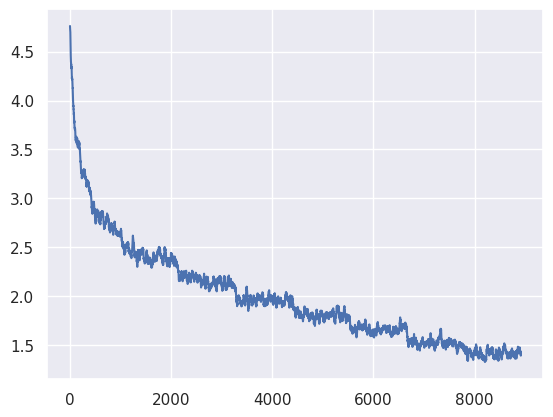

In [ ]:
# Graph the loss

window_size = 30
smoothed_losses = []
for i in range(len(losses)-window_size):
  smoothed_losses.append(np.mean(losses[i:i+window_size]))

plt.plot(smoothed_losses[100:])

# Manual Testing

In [ ]:
test_sentence = test_dataset[0]['translation']['en']
print('Raw input text:', test_sentence)

input_ids = encode_input_str(
    text = test_sentence,
    target_lang = 'hi',
    tokenizer = tokenizer,
    seq_len = model.config.max_length,
    lang_token_map = LANG_TOKEN_MAPPING)
input_ids = input_ids.unsqueeze(0).cuda()

print('Truncated input text:', tokenizer.convert_tokens_to_string(
    tokenizer.convert_ids_to_tokens(input_ids[0])))

Raw input text: It has been confirmed that eight thoroughbred race horses at Randwick Racecourse in Sydney have been infected with equine influenza.
Truncated input text: <hi> It has been confirmed that eight thoroughbred race horses at Randwick Racecourse</s>


In [ ]:
output_tokens = model.generate(input_ids, num_beams=10, num_return_sequences=3)
# print(output_tokens)
for token_set in output_tokens:
  print(tokenizer.decode(token_set, skip_special_tokens=True))

/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1273: UserWarning: Using the model-agnostic default `max_length` (=20) to control the generation length. We recommend setting `max_new_tokens` to control the maximum length of the generation.
  warnings.warn(


यह पुष्टि की गई है कि रैंडविक रेस कक्ष में आ
यह पुष्टि की गई है कि रैंडविक रेस क्रॉस में
यह पुष्टि की गई है कि रैंडविक रेस कुर्सल में
